In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pipeline import eval_pipeline, HierarchicalImputer, CoordinateTransformer, WindDirectionTransformer, DropColumnsTransformer, RainTodayTransformer, ExpandDateTransformer, sample, report_results
from persistence import load_or_fit
# For data manipulation
import pandas as pd
import numpy as np
import pandas as pd
# For visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
import joblib

In [3]:
rains = pd.read_csv('../data/weatherAUS.csv')
rains = rains.dropna(subset=['RainTomorrow'])
# Convierto la variable 'Date' a formato tipo "datetime" de Pandas

rains_x = rains.drop(columns=['RainTomorrow'])  # Drop the target column from features
rains_y = np.where(rains['RainTomorrow'] == "Yes", 1, 0)                 # Target variable

# Split the dataset
rnd_seed = 42   # For reproducibility         
ftest = 0.20    # Fracción de datos para "train"

X_train, X_test, y_train, y_test = train_test_split(rains_x, rains_y,
                                                    test_size=ftest,
                                                    stratify=rains_y,
                                                    random_state=rnd_seed)

print("Dimension de X_train:",X_train.shape)
print("Valores de y_train:",y_train.size)
print("Dimension de X_test:",X_test.shape)
print("Valores de y_test:",len(y_test))

Dimension de X_train: (113754, 22)
Valores de y_train: 113754
Dimension de X_test: (28439, 22)
Valores de y_test: 28439


In [4]:
coordinates = pd.read_csv("../data/worldcities.csv")
coordinates["Location"] = coordinates["city"]
coordinates.drop(columns=["city"], inplace = True)
coordinates = coordinates[coordinates["country"] == "Australia"]

city_coords = {
    'Albury': (-36.0785, 146.9136),
    'BadgerysCreek': (-33.8813, 150.7282),
    'Cobar': (-31.8667, 145.7667),
    'CoffsHarbour': (-30.3026, 153.1137),
    'Moree': (-29.4706, 149.8392),
    'Newcastle': (-32.9283, 151.7817),
    'NorahHead': (-33.2202, 151.5433),
    'NorfolkIsland': (-29.0408, 167.9541),
    'Penrith': (-33.7675, 150.6931),
    'Richmond': (-33.5982, 150.7581),
    'Sydney': (-33.8688, 151.2093),
    'SydneyAirport': (-33.9399, 151.1753),
    'WaggaWagga': (-35.0433, 147.3587),
    'Williamtown': (-32.7951, 151.8118),
    'Wollongong': (-34.4278, 150.8931),
    'Canberra': (-35.2809, 149.1300),
    'Tuggeranong': (-35.4167, 149.1000),
    'MountGinini': (-35.4471, 148.9685),
    'Ballarat': (-37.5622, 143.8503),
    'Bendigo': (-36.7582, 144.2814),
    'Sale': (-38.1100, 147.0737),
    'MelbourneAirport': (-37.6692, 144.8411),
    'Melbourne': (-37.8136, 144.9631),
    'Mildura': (-34.1850, 142.1625),
    'Nhil': (-35.2060, 141.6450),
    'Portland': (-38.3516, 141.5878),
    'Watsonia': (-37.7139, 145.0875),
    'Dartmoor': (-37.7251, 141.2843),
    'Brisbane': (-27.4698, 153.0251),
    'Cairns': (-16.9203, 145.7710),
    'GoldCoast': (-28.0167, 153.4000),
    'Townsville': (-19.2589, 146.8183),
    'Adelaide': (-34.9285, 138.6007),
    'MountGambier': (-37.8321, 140.7807),
    'Nuriootpa': (-34.4973, 138.9966),
    'Woomera': (-31.1395, 136.7984),
    'Albany': (-35.0285, 117.8837),
    'Witchcliffe': (-33.7015, 115.0911),
    'PearceRAAF': (-31.9131, 115.9741),
    'PerthAirport': (-31.9402, 115.9676),
    'Perth': (-31.9505, 115.8605),
    'SalmonGums': (-33.3937, 121.2060),
    'Walpole': (-34.9639, 115.8106),
    'Hobart': (-42.8821, 147.3272),
    'Launceston': (-41.4391, 147.1349),
    'AliceSprings': (-23.6980, 133.8807),
    'Darwin': (-12.4634, 130.8456),
    'Katherine': (-14.4686, 132.2678),
    'Uluru': (-25.3444, 131.0369)
}

# Categorical => numerical

Se transforman las direcciones cardinales en grados, ej NE -> 0.22

Se transforma la ubicacion (Location) en latitud y longitud, ej Albury => (-36.0785, 146.9136)

In [14]:
num_minmax_logit =  Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
    ("scaler", MinMaxScaler()),
    ("logistic_regression", LogisticRegression())
], memory="pipeline_cache")


parameters = {
    'scaler': [MinMaxScaler(), StandardScaler()],
    'logistic_regression__class_weight':['balanced', {1: 0.60, 0: 0.40}, {1: 0.75, 0: 0.25}, {1: 0.85, 0: 0.15}, {1: 0.95, 0: 0.05}, None],
    'logistic_regression__penalty':['l2']
}

clf = GridSearchCV(num_minmax_logit, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=1)
gs_fitted = load_or_fit(clf, x, y, name="num-minmax-logit")
y_pred = gs_fitted.predict(X_train)
report_results(y_train, y_pred)
print(gs_fitted.best_params_)
print(gs_fitted.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Saving: num-minmax-logit-4755.pkl


Accuracy: 0.8026530935175906

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87     88252
           1       0.54      0.74      0.63     25502

    accuracy                           0.80    113754
   macro avg       0.73      0.78      0.75    113754
weighted avg       0.83      0.80      0.81    113754


 Roc auc Report:
 0.7813759546052652
{'logistic_regression__class_weight': {1: 0.75, 0: 0.25}, 'logistic_regression__penalty': 'l2', 'scaler': StandardScaler()}
0.6275145241670977


###  Missclassifications

In [65]:
num_minmax_logit_preproc =  Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
], memory="pipeline_cache")
x_t = num_minmax_logit_preproc.fit_transform(x)

/tmp/ipykernel_382068/300980677.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missclassified['target'] = y[y != y_pred]


<Figure size 1000x1000 with 0 Axes>

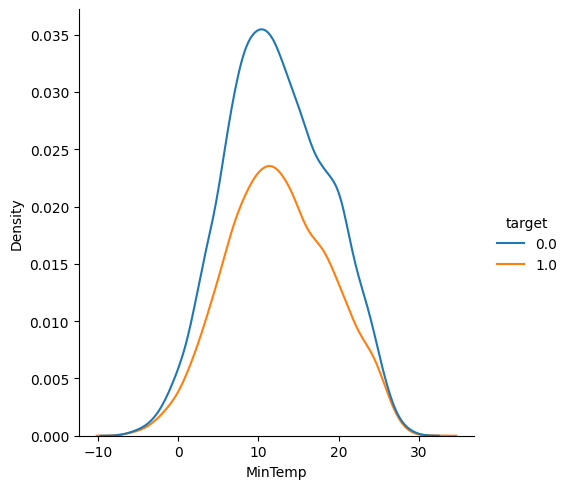

<Figure size 1000x1000 with 0 Axes>

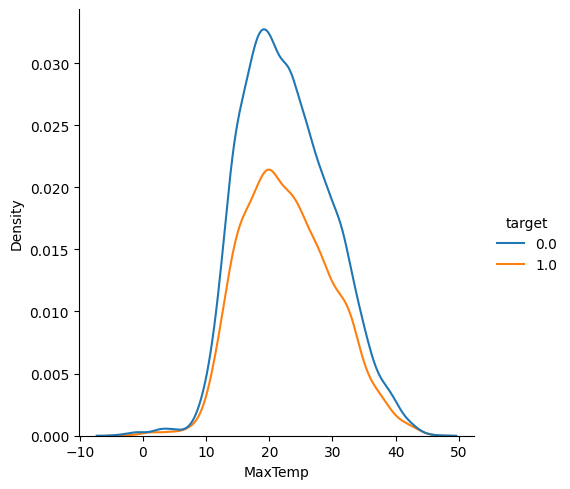

<Figure size 1000x1000 with 0 Axes>

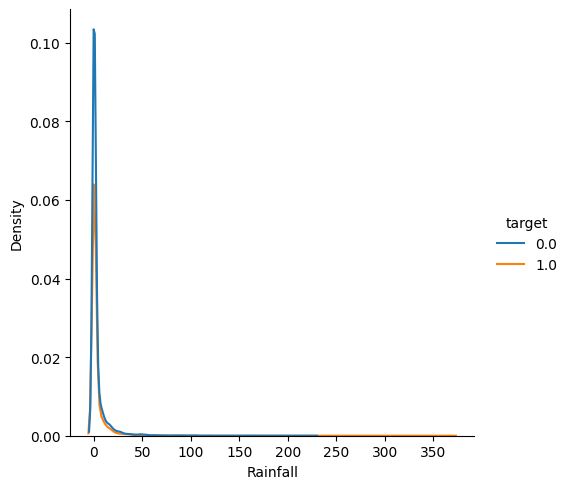

<Figure size 1000x1000 with 0 Axes>

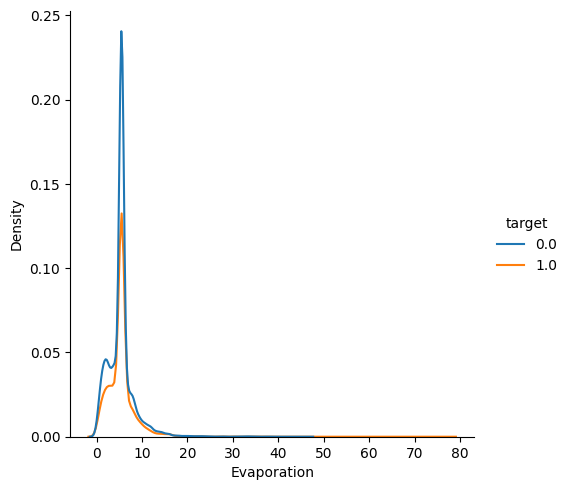

<Figure size 1000x1000 with 0 Axes>

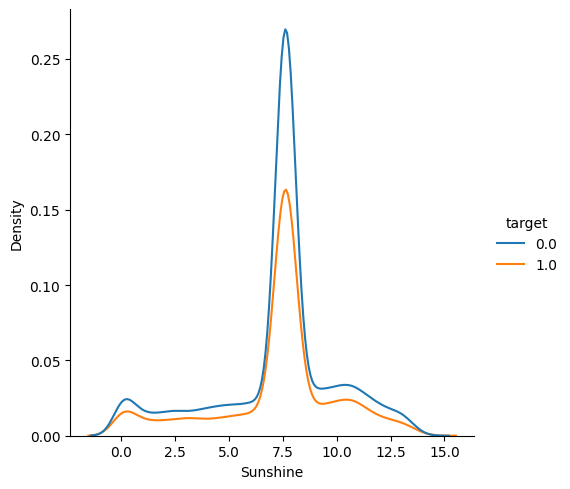

<Figure size 1000x1000 with 0 Axes>

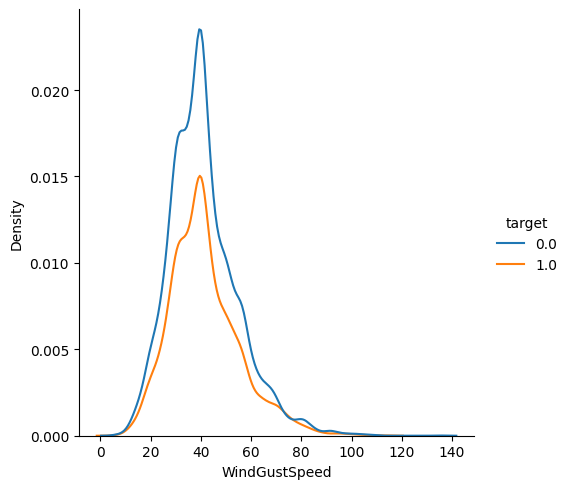

<Figure size 1000x1000 with 0 Axes>

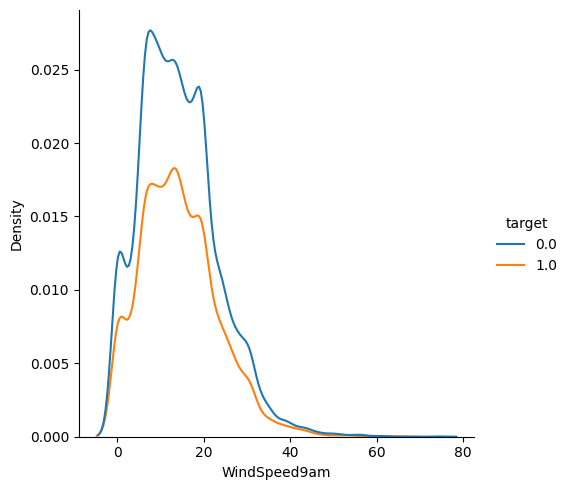

<Figure size 1000x1000 with 0 Axes>

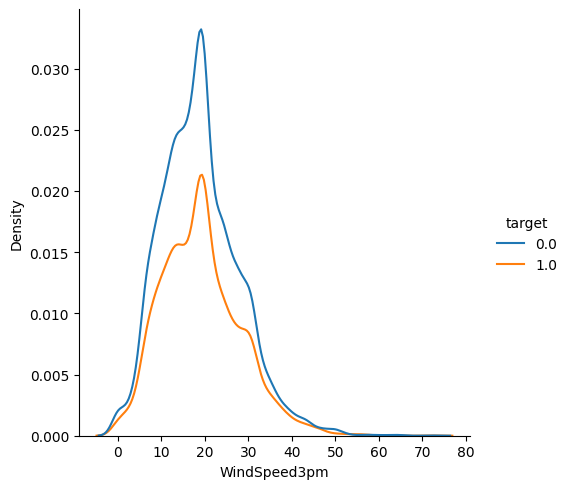

<Figure size 1000x1000 with 0 Axes>

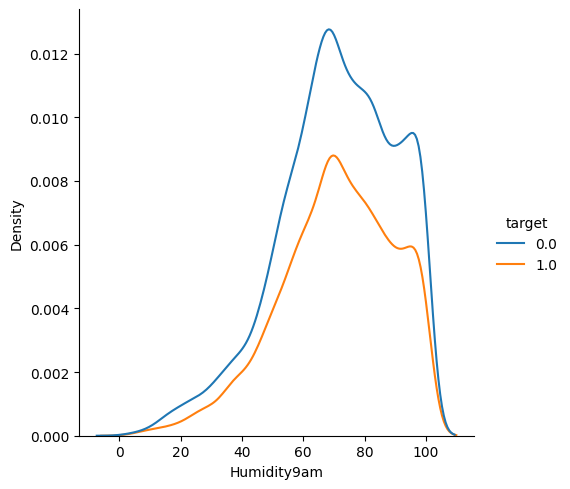

<Figure size 1000x1000 with 0 Axes>

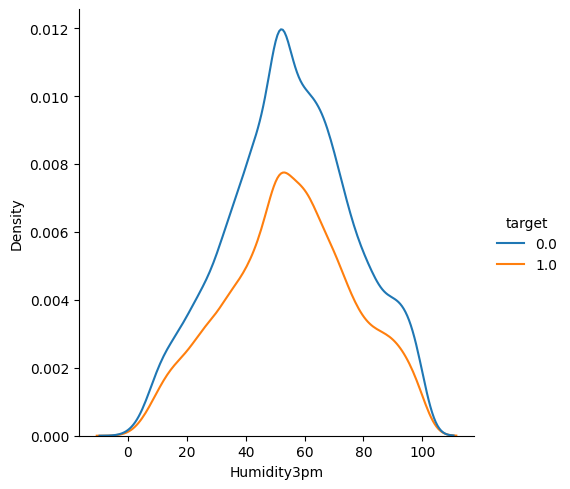

<Figure size 1000x1000 with 0 Axes>

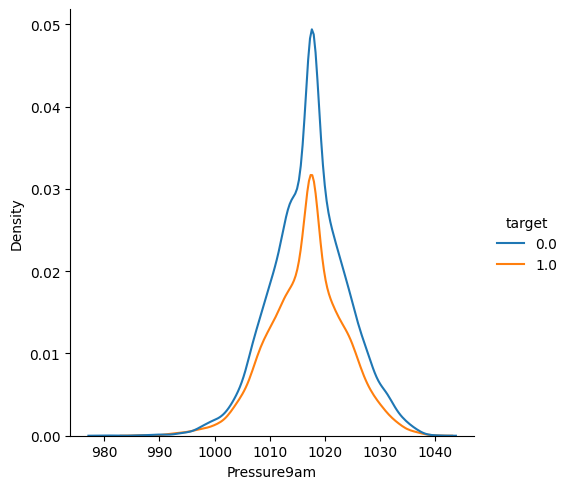

<Figure size 1000x1000 with 0 Axes>

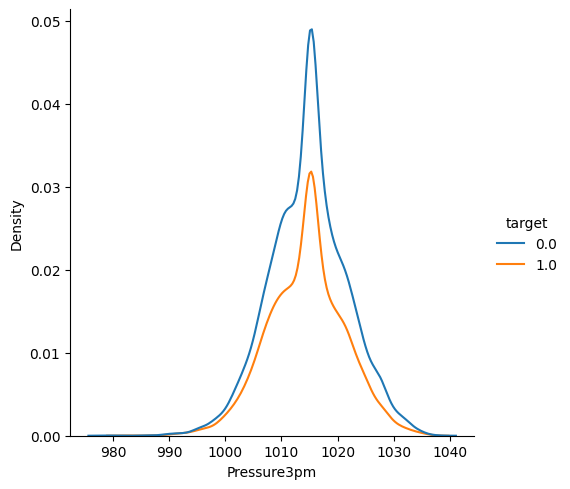

<Figure size 1000x1000 with 0 Axes>

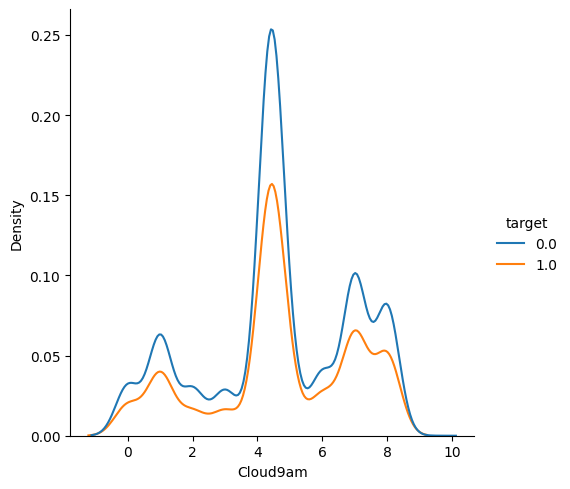

<Figure size 1000x1000 with 0 Axes>

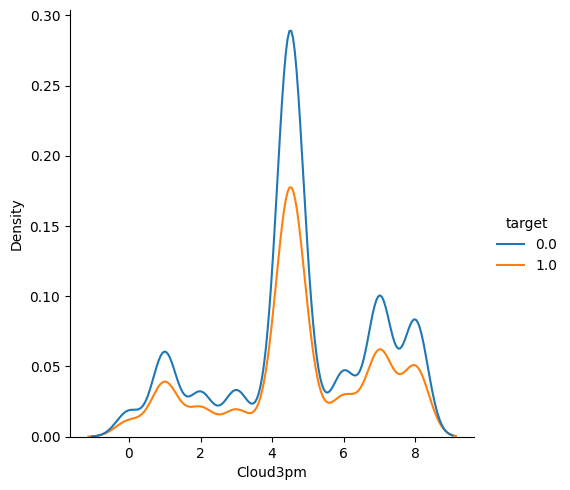

<Figure size 1000x1000 with 0 Axes>

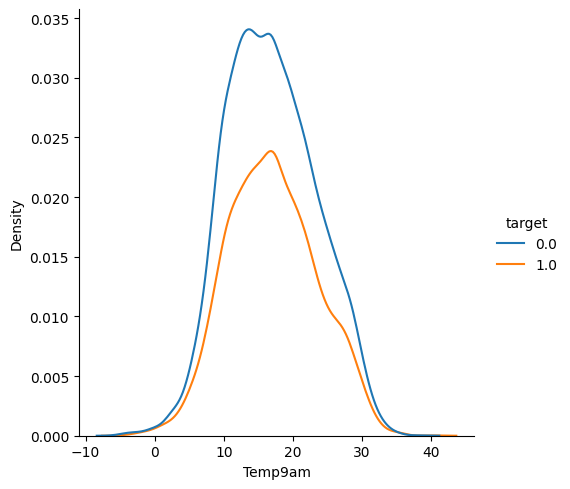

<Figure size 1000x1000 with 0 Axes>

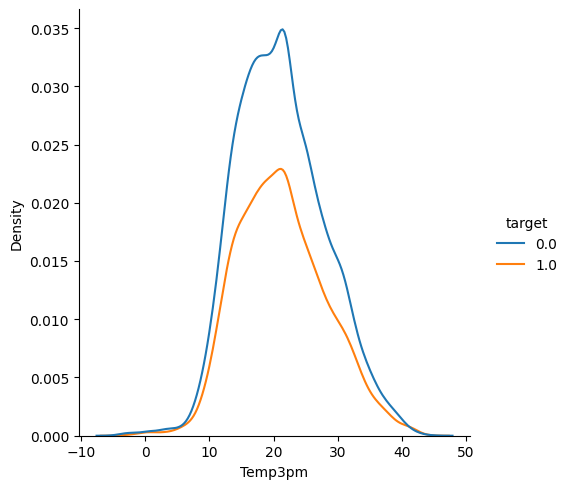

<Figure size 1000x1000 with 0 Axes>

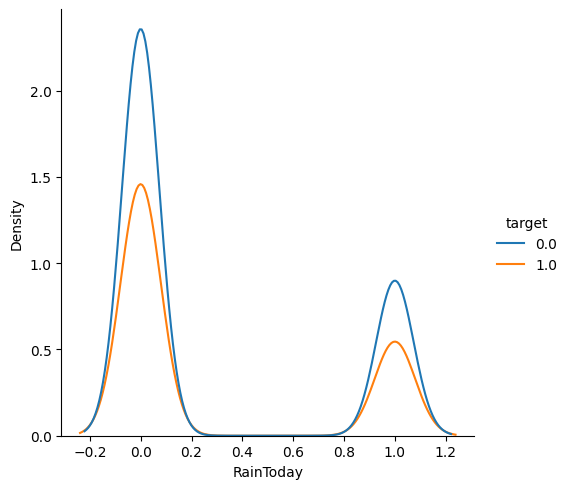

<Figure size 1000x1000 with 0 Axes>

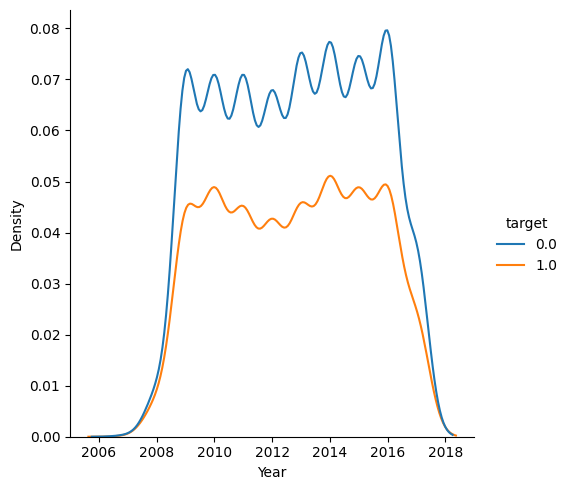

<Figure size 1000x1000 with 0 Axes>

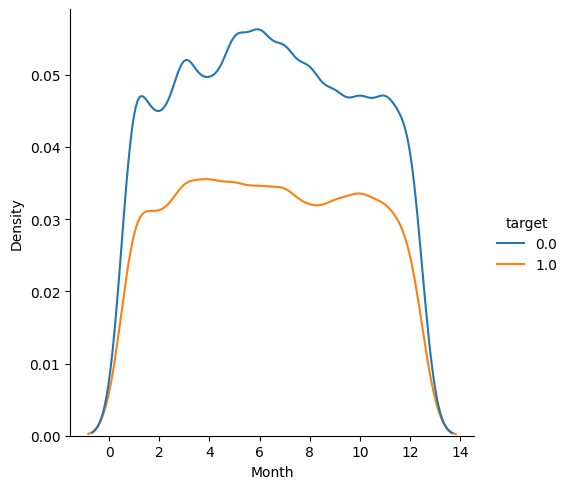

<Figure size 1000x1000 with 0 Axes>

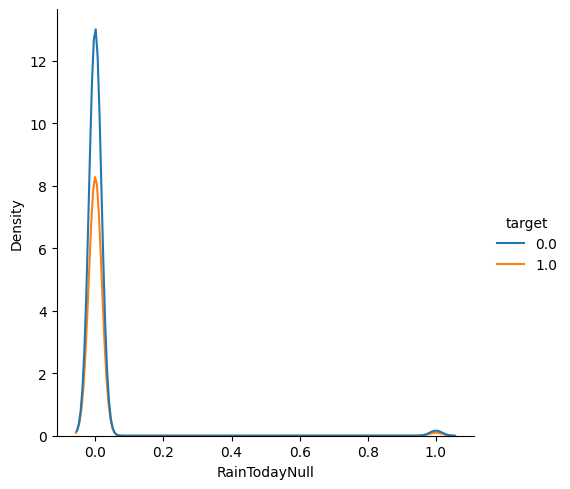

<Figure size 1000x1000 with 0 Axes>

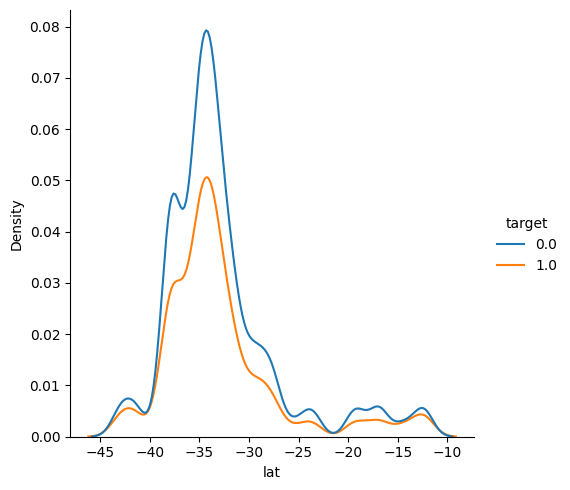

<Figure size 1000x1000 with 0 Axes>

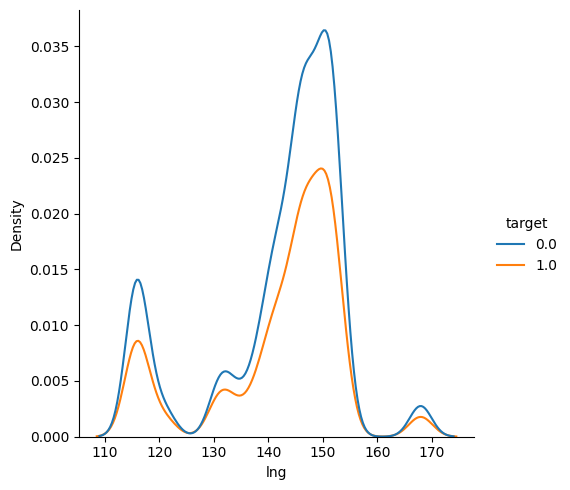

<Figure size 1000x1000 with 0 Axes>

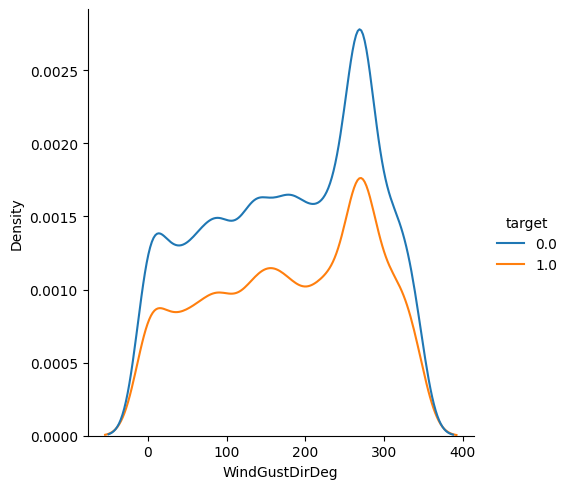

<Figure size 1000x1000 with 0 Axes>

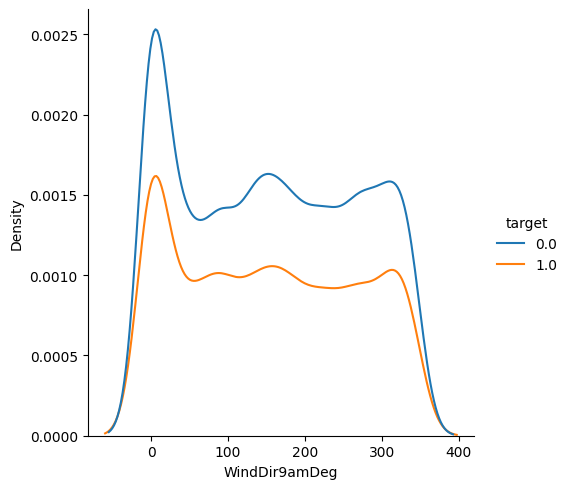

<Figure size 1000x1000 with 0 Axes>

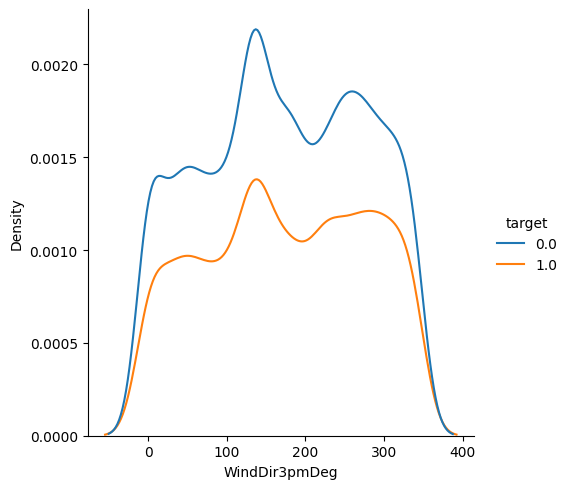

In [56]:
missclassified = x_t[(y_pred != y).reset_index(drop=True)]
missclassified['target'] = y[y != y_pred]
for c in x_t.columns:
  plt.figure(figsize=(10,10))
  sns.displot(data=missclassified, x=c, hue='target', kind="kde")
  plt.show()

##  Elasticnet

In [8]:
num_minmax_logit =  Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
    ("scaler", MinMaxScaler()),
    ("logistic_regression", LogisticRegression())
])


parameters = {
    'scaler': [MinMaxScaler(), StandardScaler()],
    'logistic_regression__class_weight':[{1: 0.75, 0: 0.25}],
    'logistic_regression__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.95],
    'logistic_regression__solver': ['saga'],
    'logistic_regression__penalty': ['elasticnet'],
    'logistic_regression__C': [2.0, 5.0],
    'logistic_regression__max_iter': [1000]
}

clf = GridSearchCV(num_minmax_logit, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=1)
gs_fitted = load_or_fit(clf, x, y, name="num-minmax-logit-elastic")
print(gs_fitted.best_params_)
report_results(y_train, gs_fitted.predict(X_train))


{'logistic_regression__C': 5.0, 'logistic_regression__class_weight': {1: 0.75, 0: 0.25}, 'logistic_regression__l1_ratio': 0.95, 'logistic_regression__max_iter': 1000, 'logistic_regression__penalty': 'elasticnet', 'logistic_regression__solver': 'saga', 'scaler': MinMaxScaler()}


Accuracy: 0.8026267208186085

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87     88252
           1       0.54      0.74      0.63     25502

    accuracy                           0.80    113754
   macro avg       0.73      0.78      0.75    113754
weighted avg       0.83      0.80      0.81    113754


 Roc auc Report:
 0.7813728985347294


In [ ]:
results = pd.DataFrame(gs_fitted.cv_results_)
results[results["rank_test_score"] <= 3]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic_regression__class_weight,param_logistic_regression__l1_ratio,param_logistic_regression__penalty,param_logistic_regression__solver,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,4.070496,0.781790,0.724000,0.198347,"{1: 0.75, 0: 0.25}",0.25,elasticnet,saga,StandardScaler(),{'logistic_regression__class_weight': {1: 0.75...,0.645747,0.637705,0.615649,0.619556,0.604491,0.624630,0.015026,3
7,4.736079,0.021802,0.829117,0.088446,"{1: 0.75, 0: 0.25}",0.75,elasticnet,saga,StandardScaler(),{'logistic_regression__class_weight': {1: 0.75...,0.646816,0.640984,0.614987,0.618930,0.605172,0.625378,0.015880,1
9,2.340384,0.029444,0.389741,0.022670,"{1: 0.75, 0: 0.25}",0.95,elasticnet,saga,StandardScaler(),{'logistic_regression__class_weight': {1: 0.75...,0.646816,0.640984,0.614458,0.618930,0.605172,0.625272,0.015951,2


Exploramos mas el rango $0.25 <= l1 0.75$

In [138]:
num_minmax_logit =  Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
    ("scaler", MinMaxScaler()),
    ("logistic_regression", LogisticRegression())
])


parameters = {
    'scaler': [MinMaxScaler(), StandardScaler()],
    'logistic_regression__class_weight':[{1: 0.75, 0: 0.25}],
    'logistic_regression__l1_ratio': [0.25, 0.35, 0.45, 0.65, 0.75],
    'logistic_regression__solver': ['saga'],
    'logistic_regression__penalty': ['elasticnet'],
}

clf = GridSearchCV(num_minmax_logit, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=0.1)
gs_fitted = load_or_fit(clf, x, y, name="num-minmax-logit-elastic")
print(gs_fitted.best_params_)
report_results(y_train, gs_fitted.predict(X_train))


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Saving: num-minmax-logit-elastic-1634.pkl
{'logistic_regression__class_weight': {1: 0.75, 0: 0.25}, 'logistic_regression__l1_ratio': 0.75, 'logistic_regression__penalty': 'elasticnet', 'logistic_regression__solver': 'saga', 'scaler': StandardScaler()}


Accuracy: 0.803417901788069

 Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.82      0.87     88252
           1       0.55      0.73      0.63     25502

    accuracy                           0.80    113754
   macro avg       0.73      0.78      0.75    113754
weighted avg       0.83      0.80      0.81    113754


 Roc auc Report:
 0.7785649126781563


In [139]:
results = pd.DataFrame(gs_fitted.cv_results_)
results[results["rank_test_score"] <= 3]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic_regression__class_weight,param_logistic_regression__l1_ratio,param_logistic_regression__penalty,param_logistic_regression__solver,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,3.859030,0.963758,0.701767,0.175408,"{1: 0.75, 0: 0.25}",0.35,elasticnet,saga,StandardScaler(),{'logistic_regression__class_weight': {1: 0.75...,0.616967,0.615649,0.601227,0.601185,0.613223,0.609650,0.006998,3
5,3.271553,0.524254,0.598792,0.159636,"{1: 0.75, 0: 0.25}",0.45,elasticnet,saga,StandardScaler(),{'logistic_regression__class_weight': {1: 0.75...,0.616967,0.615649,0.601227,0.601185,0.613223,0.609650,0.006998,3
7,3.886000,0.993439,0.688643,0.193535,"{1: 0.75, 0: 0.25}",0.65,elasticnet,saga,StandardScaler(),{'logistic_regression__class_weight': {1: 0.75...,0.616967,0.615649,0.601227,0.601695,0.613730,0.609854,0.006931,2
9,2.723910,0.231482,0.407015,0.027385,"{1: 0.75, 0: 0.25}",0.75,elasticnet,saga,StandardScaler(),{'logistic_regression__class_weight': {1: 0.75...,0.617496,0.615649,0.601227,0.601695,0.614238,0.610061,0.007099,1


Exploramos mas el rango $0.0.75 <= l1 1.0$

In [140]:
num_minmax_logit =  Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
    ("scaler", MinMaxScaler()),
    ("logistic_regression", LogisticRegression())
])


parameters = {
    'scaler': [MinMaxScaler(), StandardScaler()],
    'logistic_regression__class_weight':[{1: 0.75, 0: 0.25}],
    'logistic_regression__l1_ratio': [0.75, 0.80, 0.85, 0.90, 0.95, 1.0],
    'logistic_regression__solver': ['saga'],
    'logistic_regression__penalty': ['elasticnet'],
}

clf = GridSearchCV(num_minmax_logit, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=0.1)
gs_fitted = load_or_fit(clf, x, y, name="num-minmax-logit-elastic")
print(gs_fitted.best_params_)
report_results(y_train, gs_fitted.predict(X_train))


Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocen

/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Saving: num-minmax-logit-elastic-9255.pkl
{'logistic_regression__class_weight': {1: 0.75, 0: 0.25}, 'logistic_regression__l1_ratio': 0.75, 'logistic_regression__penalty': 'elasticnet', 'logistic_regression__solver': 'saga', 'scaler': StandardScaler()}


Accuracy: 0.7995586968370343

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.86     88252
           1       0.54      0.74      0.62     25502

    accuracy                           0.80    113754
   macro avg       0.73      0.78      0.74    113754
weighted avg       0.83      0.80      0.81    113754


 Roc auc Report:
 0.7794653097924396


In [ ]:
results = pd.DataFrame(gs_fitted.cv_results_)
results[results["rank_test_score"] <= 3]

# One hot encoding categorical features


In [57]:
categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first"))
])

numerical_transformer = Pipeline(steps=[
    ("minmax", MinMaxScaler())
])


transform_columns = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, ["Location","WindGustDir", "WindDir9am", "WindDir3pm"]),
        ("num", numerical_transformer, ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'Year', 'Month'])
    ]
)


ohe_pipeline = Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("drop_date", DropColumnsTransformer(columns=["Date"])),
    ("preproc", transform_columns),
    ("logistic_regression", LogisticRegression())
])


In [61]:
parameters = {
    'logistic_regression__class_weight':['balanced', {1: 0.60, 0: 0.40}, {1: 0.75, 0: 0.25}, {1: 0.85, 0: 0.15}, {1: 0.95, 0: 0.05}, None],
    'logistic_regression__penalty':['l2']
}
clf = GridSearchCV(ohe_pipeline, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train)
gs_fitted = load_or_fit(clf, x, y, name="ohe-logit", force=True)

print(gs_fitted.best_params_)
print(gs_fitted.best_score_)
print(gs_fitted.scorer_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


Saving: ohe-logit-196.pkl
{'logistic_regression__class_weight': {1: 0.6, 0: 0.4}, 'logistic_regression__penalty': 'l2'}
0.6163801420794797
make_scorer(f1_score, response_method='predict', average=binary)


In [62]:
report_results(y_train, gs_fitted.predict(X_train))

Accuracy: 0.8406121982523691

 Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90     88252
           1       0.67      0.57      0.62     25502

    accuracy                           0.84    113754
   macro avg       0.78      0.74      0.76    113754
weighted avg       0.83      0.84      0.84    113754


 Roc auc Report:
 0.7443056892644423


## OHE con newton-cholesky

In [146]:
parameters = {
    'logistic_regression__class_weight':['balanced', {1: 0.60, 0: 0.40}, {1: 0.75, 0: 0.25}, {1: 0.85, 0: 0.15}, {1: 0.95, 0: 0.05}, None],
    'logistic_regression__penalty':['l2'],
    'logistic_regression__solver': ['newton-cholesky']
}
clf = GridSearchCV(ohe_pipeline, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=0.3)
gs_fitted = load_or_fit(clf, x, y, name="ohe-logit-nc")

print(gs_fitted.best_params_)
print(gs_fitted.best_score_)
print(gs_fitted.scorer_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


Saving: ohe-logit-nc-5197.pkl
{'logistic_regression__class_weight': {1: 0.75, 0: 0.25}, 'logistic_regression__penalty': 'l2', 'logistic_regression__solver': 'newton-cholesky'}
0.6286214215567321
make_scorer(f1_score, response_method='predict', average=binary)


In [147]:
report_results(y_train, gs_fitted.predict(X_train))

Accuracy: 0.803417901788069

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87     88252
           1       0.55      0.74      0.63     25502

    accuracy                           0.80    113754
   macro avg       0.73      0.78      0.75    113754
weighted avg       0.83      0.80      0.81    113754


 Roc auc Report:
 0.7819664462614495


# Exploration

In [58]:
num_minmax_p =  Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
 ])

x, y = sample(X_train, y_train)

x_t = num_minmax_p.fit_transform(x)

In [59]:
x_t.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Temp3pm,RainToday,Year,Month,RainTodayNull,lat,lng,WindGustDirDeg,WindDir9amDeg,WindDir3pmDeg
0,14.8,33.9,0.000000,8.600000,10.500000,33.0,0.0,7.0,30.0,15.0,...,33.4,0,2009,4,0,-23.6980,133.8807,112.5,0.0,112.5
1,2.7,14.8,0.000000,5.622251,7.682964,35.0,4.0,15.0,96.0,43.0,...,13.9,0,2011,6,0,-33.7511,150.6942,270.0,135.0,292.5
2,17.6,27.0,2.468599,5.622251,7.682964,26.0,6.0,9.0,86.0,98.0,...,21.0,0,2017,1,1,-33.8813,150.7282,22.5,90.0,45.0
3,13.3,16.3,42.000000,5.622251,7.682964,48.0,0.0,13.0,99.0,87.0,...,13.2,1,2014,8,0,-34.9639,115.8106,337.5,0.0,315.0
4,13.6,29.5,0.000000,5.622251,12.800000,76.0,39.0,28.0,41.0,23.0,...,27.6,0,2013,11,0,-31.9131,115.9741,90.0,90.0,112.5


In [63]:
x_t.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'Year', 'Month', 'RainTodayNull',
       'lat', 'lng', 'WindGustDirDeg', 'WindDir9amDeg', 'WindDir3pmDeg'],
      dtype='object')

<Figure size 1000x1000 with 0 Axes>

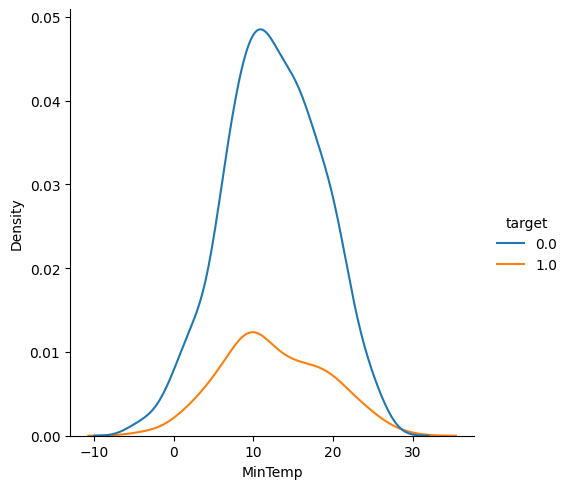

<Figure size 1000x1000 with 0 Axes>

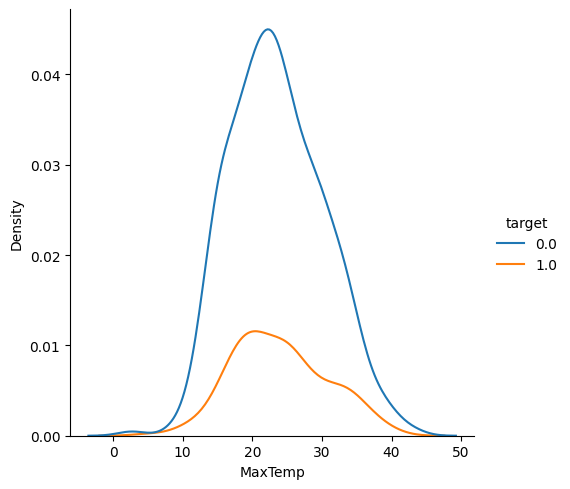

<Figure size 1000x1000 with 0 Axes>

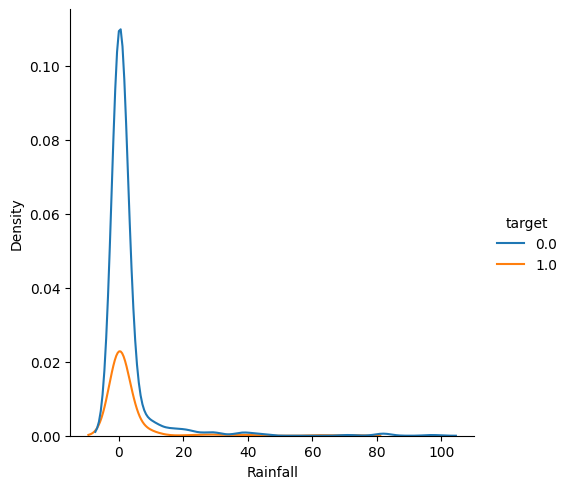

<Figure size 1000x1000 with 0 Axes>

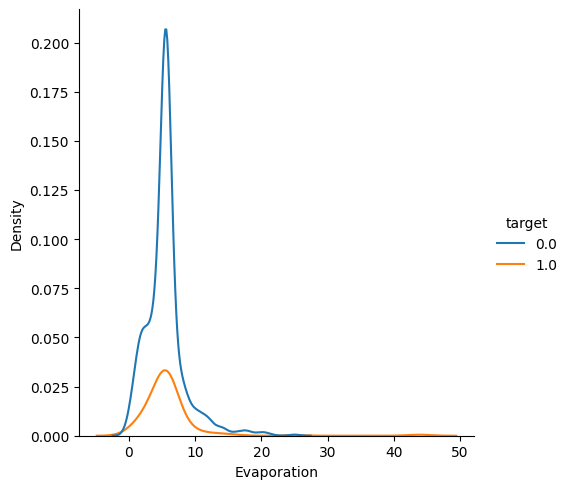

<Figure size 1000x1000 with 0 Axes>

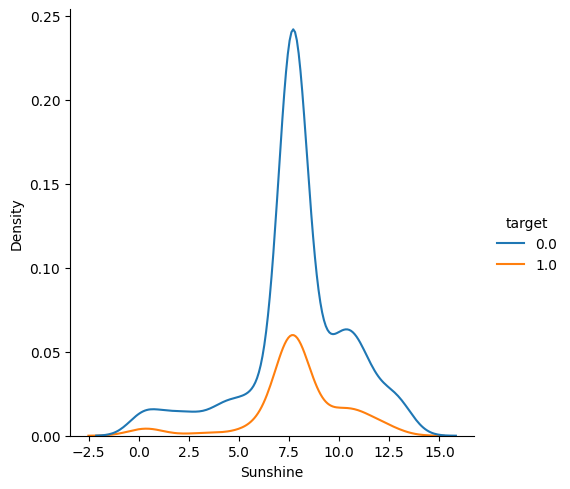

<Figure size 1000x1000 with 0 Axes>

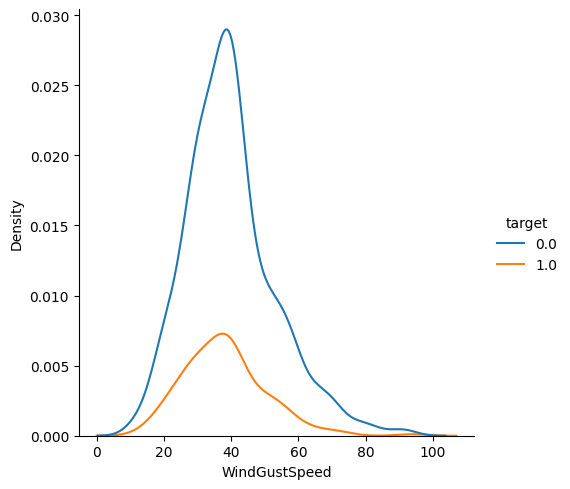

<Figure size 1000x1000 with 0 Axes>

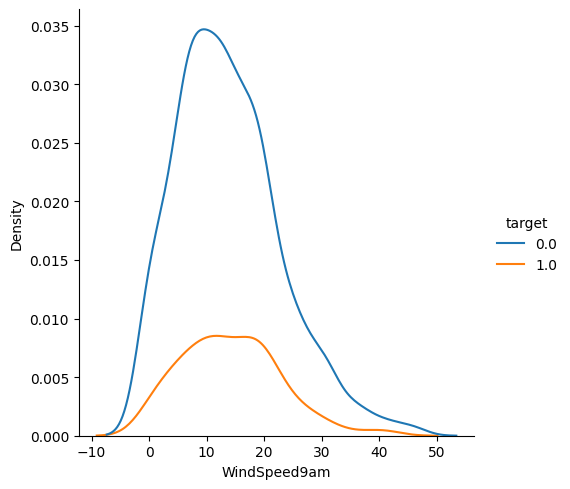

<Figure size 1000x1000 with 0 Axes>

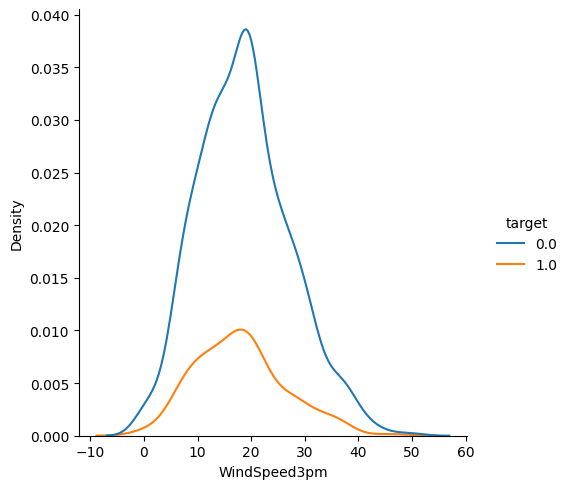

<Figure size 1000x1000 with 0 Axes>

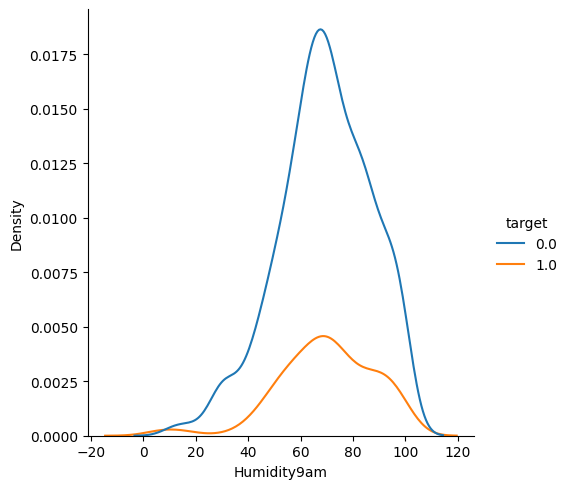

<Figure size 1000x1000 with 0 Axes>

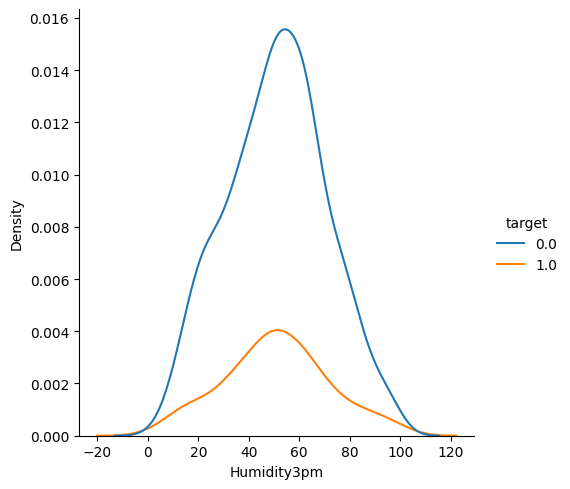

<Figure size 1000x1000 with 0 Axes>

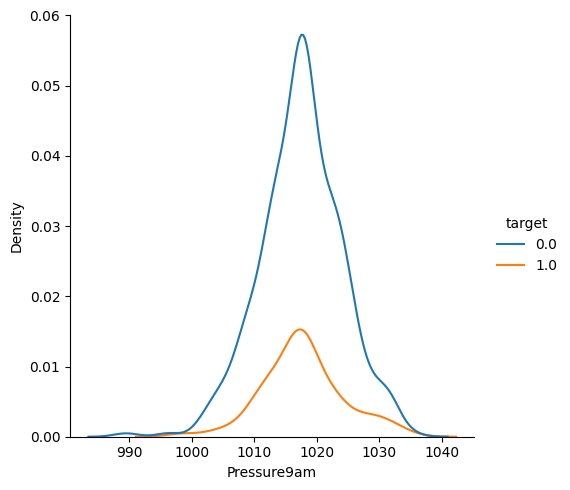

<Figure size 1000x1000 with 0 Axes>

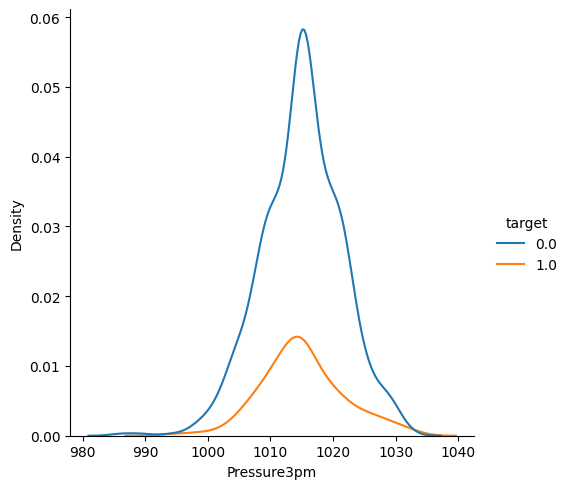

<Figure size 1000x1000 with 0 Axes>

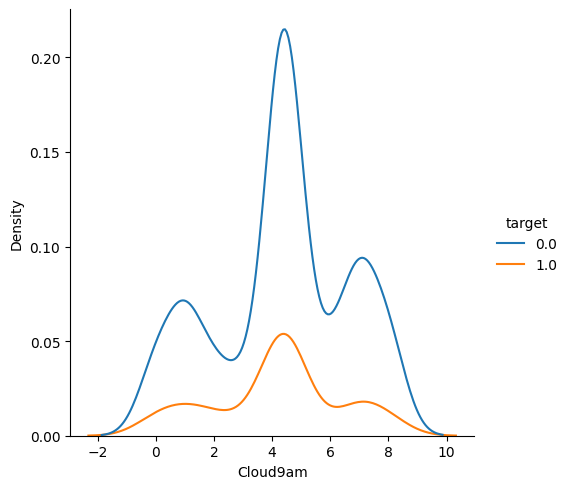

<Figure size 1000x1000 with 0 Axes>

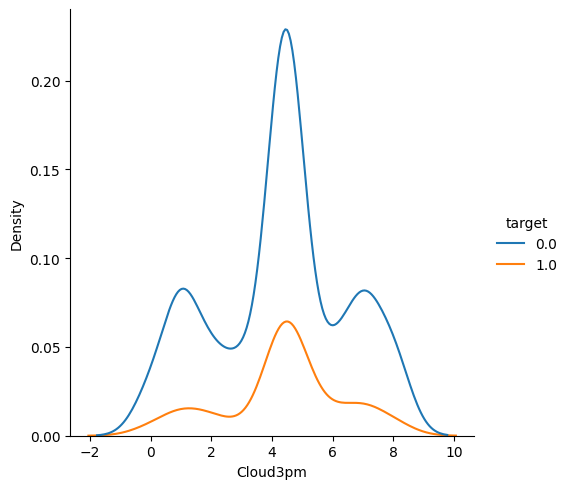

<Figure size 1000x1000 with 0 Axes>

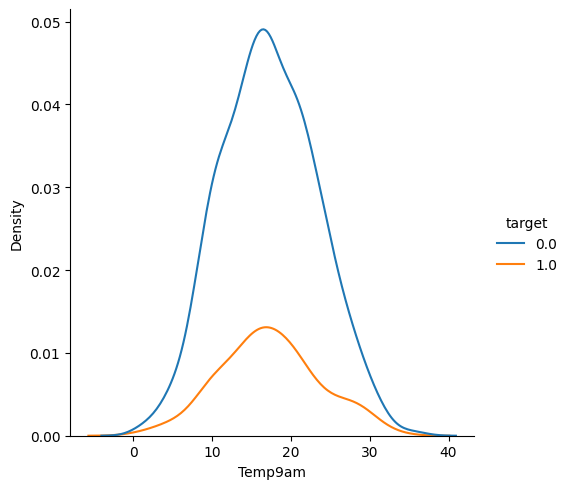

<Figure size 1000x1000 with 0 Axes>

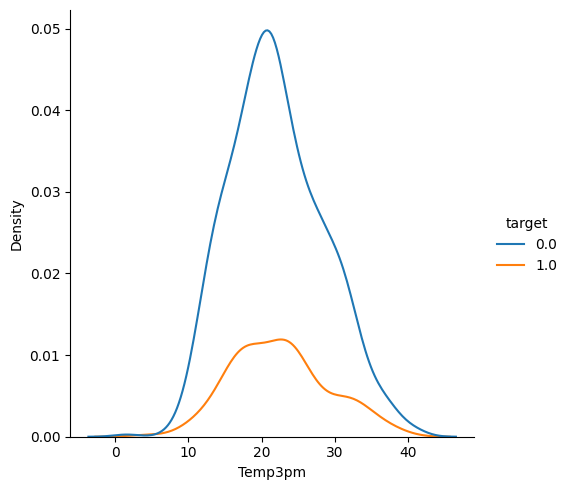

<Figure size 1000x1000 with 0 Axes>

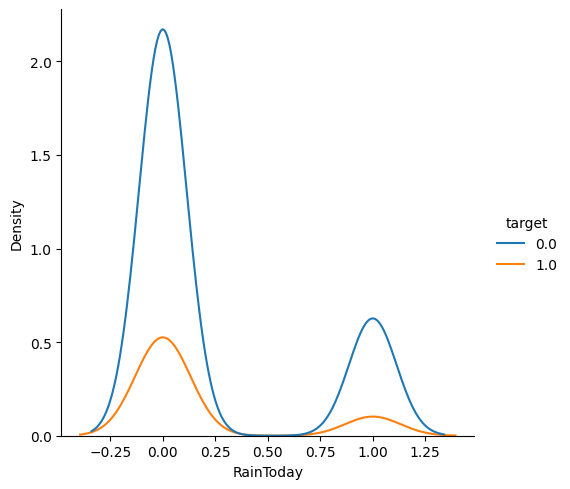

<Figure size 1000x1000 with 0 Axes>

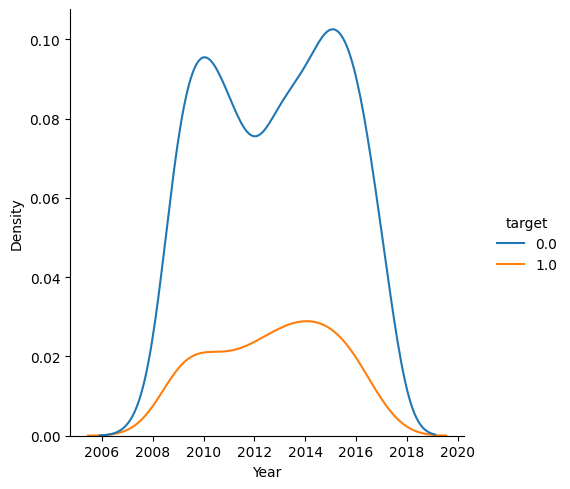

<Figure size 1000x1000 with 0 Axes>

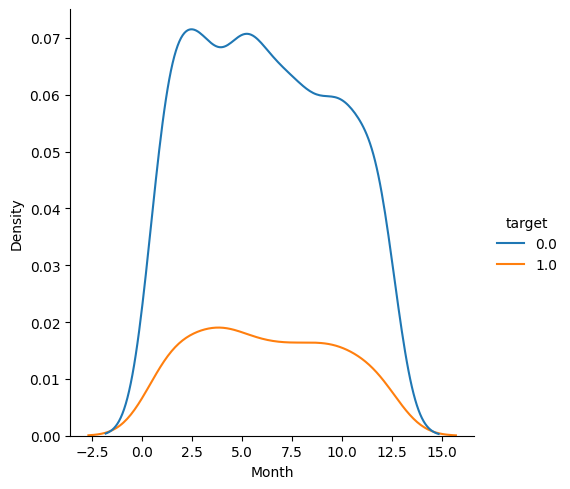

/tmp/ipykernel_240148/882813189.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(data=x_t, x=c, hue='target', kind="kde")


<Figure size 1000x1000 with 0 Axes>

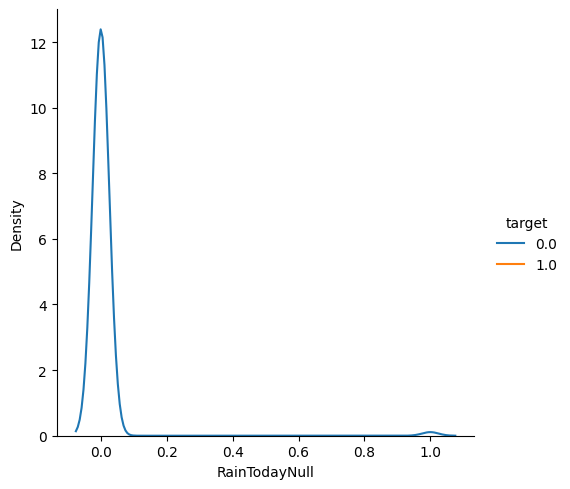

<Figure size 1000x1000 with 0 Axes>

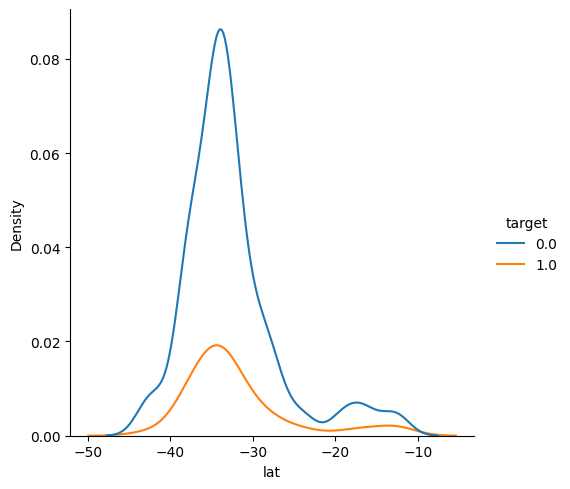

<Figure size 1000x1000 with 0 Axes>

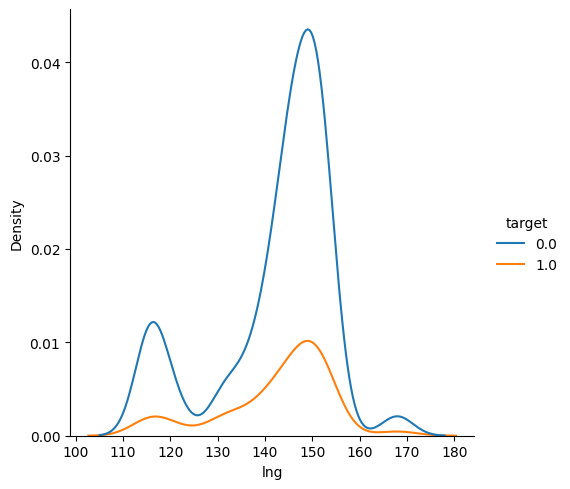

<Figure size 1000x1000 with 0 Axes>

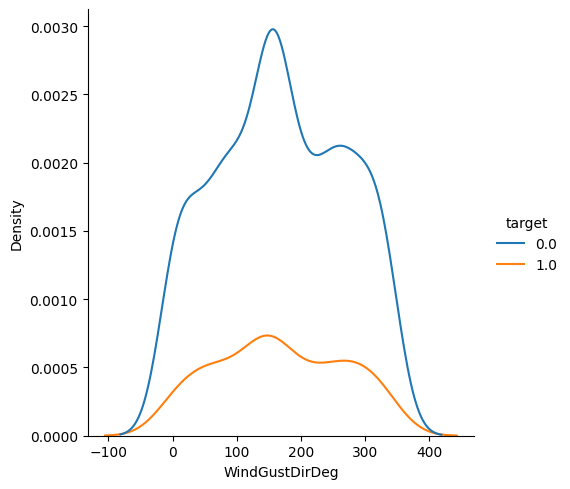

<Figure size 1000x1000 with 0 Axes>

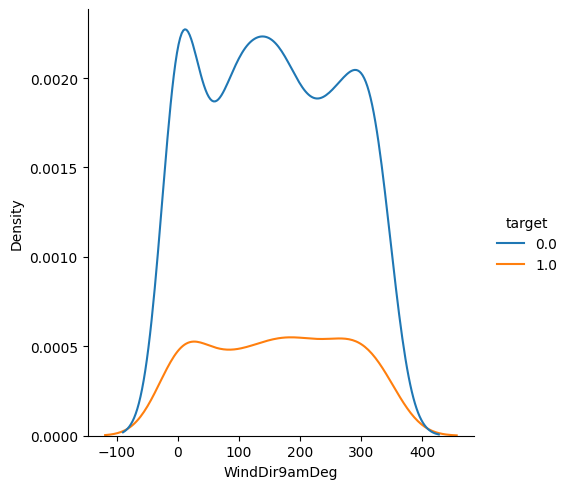

<Figure size 1000x1000 with 0 Axes>

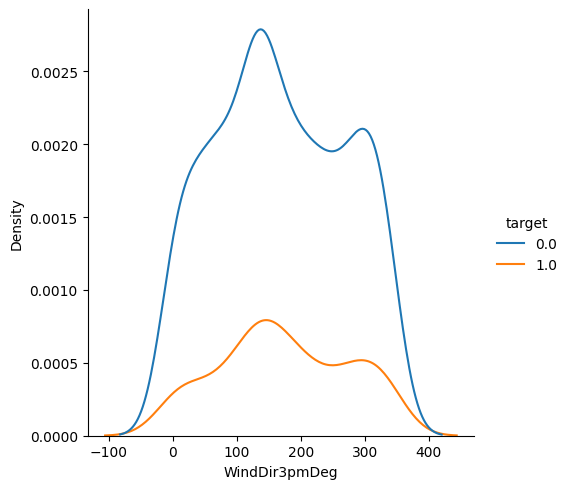

/tmp/ipykernel_240148/882813189.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(data=x_t, x=c, hue='target', kind="kde")


<Figure size 1000x1000 with 0 Axes>

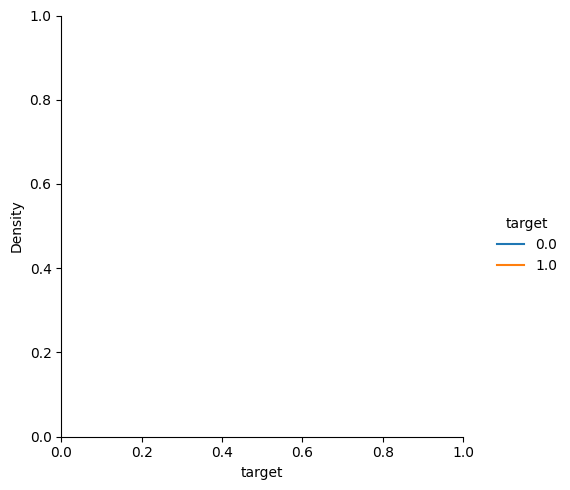

In [99]:
y_t = y.reset_index(drop=True)
x_t['target'] = y
for c in x_t.columns:
  plt.figure(figsize=(10,10))
  sns.displot(data=x_t, x=c, hue='target', kind="kde")
  plt.show()

0        False
1        False
2         True
3         True
4        False
         ...  
11370    False
11371    False
11372    False
11373    False
11374     True
Name: target, Length: 11375, dtype: bool

In [84]:
x_t["Rainfall"]>0

0        False
1        False
2         True
3         True
4        False
         ...  
11370     True
11371    False
11372    False
11373    False
11374    False
Name: Rainfall, Length: 11375, dtype: bool